# Soil erosion detection

**Agenda**:
1. Reading data and preparing
    1. Reading aerial image
    2. Reading label data
2. Unbalanced data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask

import geopandas as gpd
from shapely.geometry import mapping

## 1. Reading data and preparing

We utilize QGIS software to get an insight on both aerial image and accompanying shapefile.

Based on present metadata in both of these files, QGIS regognized the coordinate reference system of both files:

<img src="./img/qgis_mask.png">
<img src="./img/qgis_image.png">

We know that the image and shapefile correspond to the parts of Poltava, Kharkiv and Dnipropetrovsk oblasts. The aerial image depicts the territory with approximate dimentions 110km x 110km.

The aerial image with overlayed mask indicating soil errosion shows that the some parts of the mask are outside of aerial image:
<img src="./img/image_mask_overlayed.png" />
Also some parts of aerial image have little erosion, which suggests that either there is indeed no errosion or the errosion check simply was not performed for that territory.

### 1.A. Reading aerial image

In [3]:
AERIAL_IMAGE_PATH = 'T36UXV_20200406T083559_TCI_10m.jp2'
aerial_image_reader = rasterio.open(AERIAL_IMAGE_PATH, "r")

In [4]:
meta = aerial_image_reader.meta
aerial_image = reshape_as_image(aerial_image_reader.read())

The aerial image is 3-channel 10980x10980 image with no nodata values:

In [5]:
print(f"Dimentions = {aerial_image.shape}")
print(f"Nodata values = {aerial_image_reader.nodatavals}")

Dimentions = (10980, 10980, 3)
Nodata values = (None, None, None)


Thus the spacial resolution is approximately $10$ meters (per pixel).

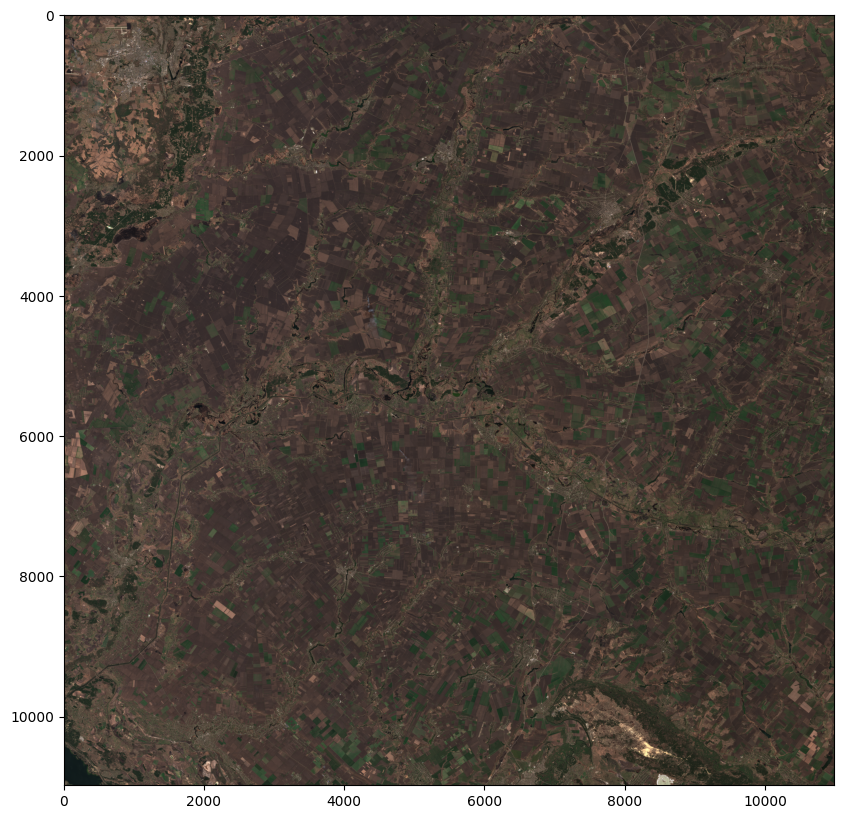

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(aerial_image);

In [7]:
aerial_image_reader.close()

### 1.B. Reading label data

Here we read the shapefile that contains polygons that indicate soil erosion: 

In [8]:
LABEL_FILE_PATH = "./masks/Masks_T36UXV_20190427.shx"
label_df = gpd.read_file(LABEL_FILE_PATH)
label_df = label_df.to_crs({'init': meta['crs']['init']})

/home/bohdan/anaconda3/envs/erosion_detection/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


The `id` and `Data` columns contain only NaNs, so we delete these columns, also we remove rows that have `null` as the value of `geometry`. Also we will remove all columns except for `geometry`, because currently they are of no use to us because of lack of understanding what they represent:

In [9]:
label_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          0 non-null      float64 
 1   Data        0 non-null      float64 
 2   Code        340 non-null    float64 
 3   Descriptio  335 non-null    object  
 4   Comments    17 non-null     object  
 5   Image       325 non-null    object  
 6   geometry    935 non-null    geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 51.3+ KB


In [10]:
label_df.drop(['id', 'Code', 'Descriptio', 'Comments', 'Image', 'Data'], axis=1, inplace=True)

In [11]:
label_df.drop(index=label_df[label_df['geometry'].isnull()].index, inplace=True)
label_df.reset_index(inplace=True)

Display part of aerial image with overlayed erosion mask:

In [12]:
shapes = [mapping(row['geometry']) for num, row in label_df.iterrows()]

In [13]:
src = rasterio.open(AERIAL_IMAGE_PATH, "r")
masked_image, out_transform = rasterio.mask.mask(src, shapes, crop=False, nodata=0)
masked_image = reshape_as_image(masked_image)
mask = masked_image != 0
mask = mask[:, :, 0] | mask[:, :, 1] | mask[:, :, 2]

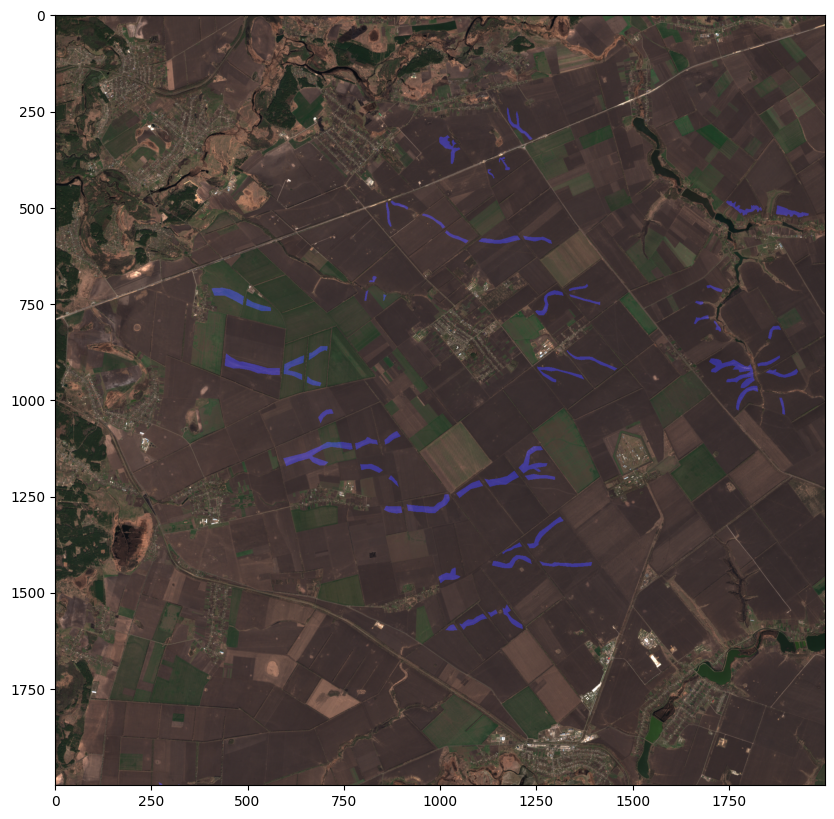

In [14]:
plt.figure(figsize=(10,10))
plt.imshow((aerial_image + np.array([5, 10, 100] * (masked_image!=0)))[0:2000, 2000:4000]);

### 3. Unbalanced data

The total area of erosion on the aerial image constitutes $0.22 \%$ of total image area.

In [29]:
erosion_percent = mask.sum() / mask.size * 100
print(f"Percent of erosion = {erosion_percent:.2f}%")

Percent of erosion = 0.22%


That suggests that we should balance the dataset before training the model.